In [1]:
#from pathlib import Path

import glob
import altair as alt
import pandas as pd
import numpy as np

## Curated telomeric coordinates, multimapped reads found within BEDfile limits

### 10X & Truseq datasets

In [2]:
colo829bl_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-10X-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-10X-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829bl = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-hg38.hist.csv", dtype={"mmap_count": np.int})

colo829bl_10x['technology'] = '10X'
colo829bl_10x['sample'] = 'colo829bl_10x'
colo829t_10x['technology'] = '10X'
colo829t_10x['sample'] = 'colo829t_10x'

colo829t['technology'] = 'Truseq'
colo829t['sample'] = 'colo829t'
colo829bl['technology'] = 'Truseq'
colo829bl['sample'] = 'colo829bl'

In [3]:
datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]
datasets_excluded_chroms = []

for ds in datasets:
    ds = ds[ds['chromosome'] != 'chr5']
    ds = ds[ds['chromosome'] != 'chr1']
    ds = ds[ds['chromosome'] != 'chrX']
    ds = ds[ds['chromosome'] != 'chr22']
    ds = ds[ds['chromosome'] != 'chrY']
    ds = ds[ds['chromosome'] != 'chr12']
    ds = ds[ds['chromosome'] != 'chr18']
    ds = ds[ds['chromosome'] != 'chr10']

    datasets_excluded_chroms.append(ds)

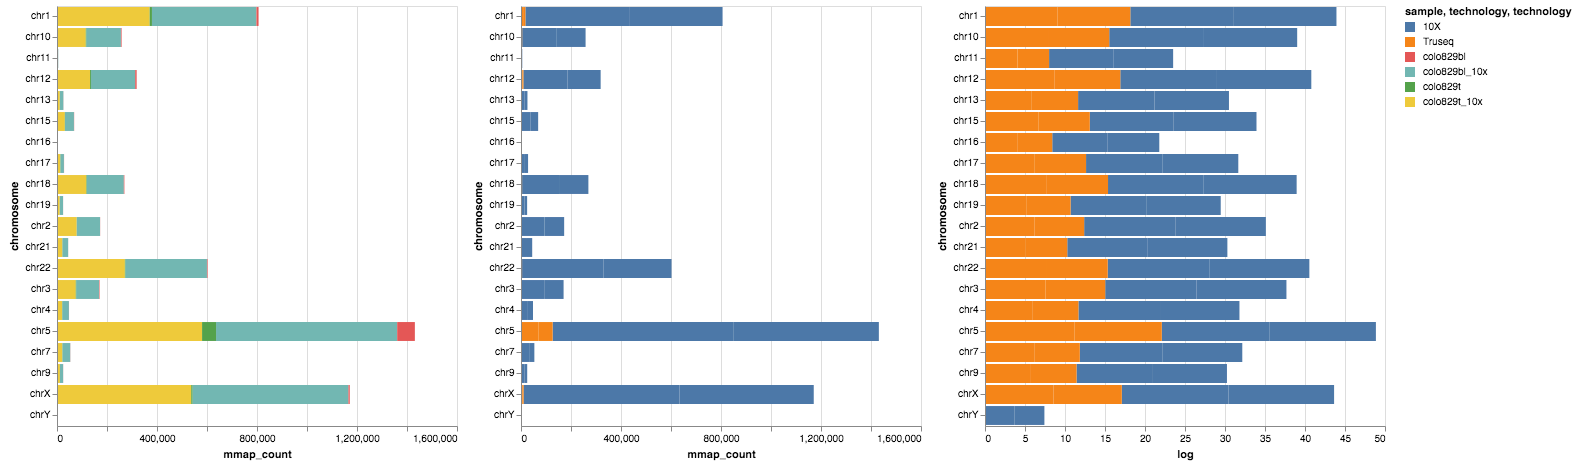

In [4]:
#dataset_curated = pd.concat(datasets_excluded_chroms, ignore_index=True)
dataset_curated = pd.concat(datasets, ignore_index=True)
dataset_curated["log"] = dataset_curated["mmap_count"].apply(np.log)

sample_chart = alt.Chart(dataset_curated).mark_bar().encode(
        x = 'mmap_count:Q',
        y = 'chromosome:N',
        color = 'sample:N'
)

tech_chart = alt.Chart(dataset_curated).mark_bar().encode(
        x = 'mmap_count:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)

logplot = alt.Chart(dataset_curated).mark_bar().encode(
        x = 'log:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)

sample_chart | tech_chart | logplot

## Absolute mapped reads for the whole datasets (samtools idxstats)

### 10X

In [5]:
colo829bl_10x_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829BL-10X-baseline-idxstats-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t_10x_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829T-10X-baseline-idxstats-hg38.hist.csv", dtype={"mmap_count": np.int})

colo829bl_10x_baseline['technology'] = '10X'
colo829bl_10x_baseline['sample'] = 'colo829bl_10x'
colo829t_10x_baseline['technology'] = '10X'
colo829t_10x_baseline['sample'] = 'colo829t_10x'

### Truseq

In [6]:
colo829bl_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829BL-baseline-idxstats-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829T-baseline-idxstats-hg38.hist.csv", dtype={"mmap_count": np.int})

colo829t_baseline['technology'] = 'Truseq'
colo829t_baseline['sample'] = 'colo829t'
colo829bl_baseline['technology'] = 'Truseq'
colo829bl_baseline['sample'] = 'colo829bl'

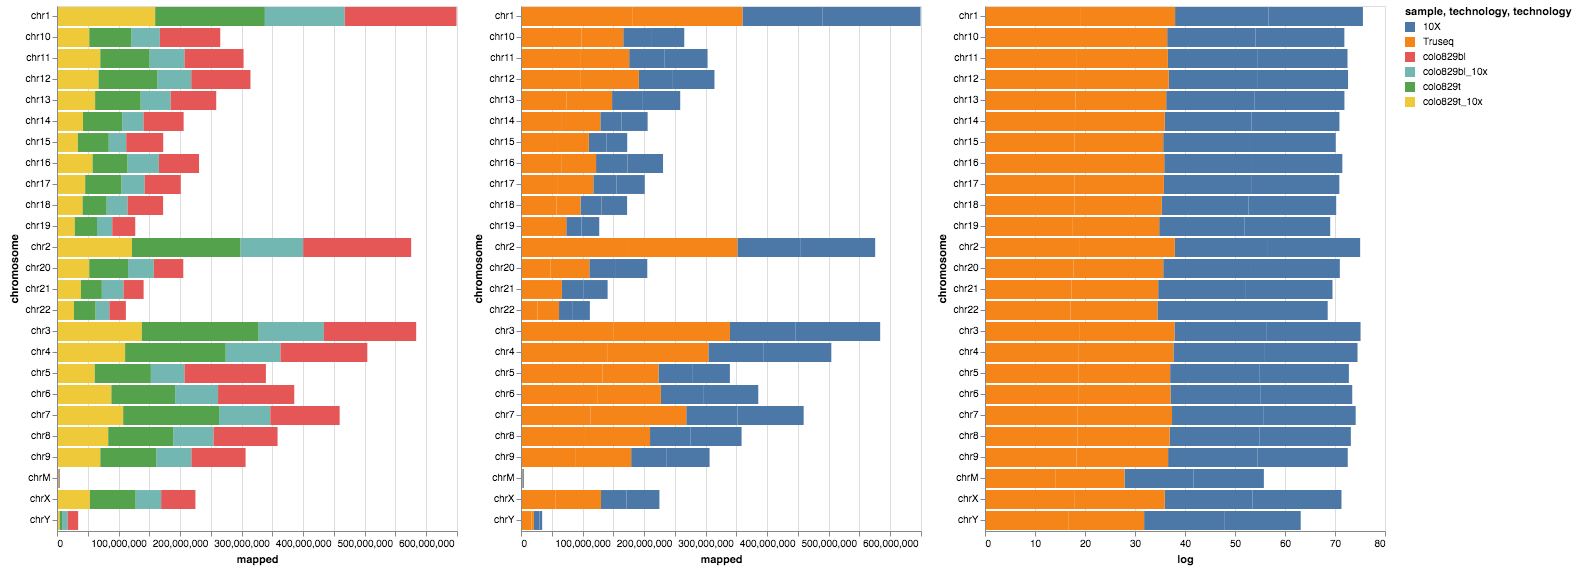

In [7]:
datasets_baseline = [colo829bl_10x_baseline, colo829t_10x_baseline, colo829bl_baseline, colo829t_baseline]
baseline_dataset = pd.concat(datasets_baseline, ignore_index=True)
baseline_dataset["log"] = baseline_dataset["mapped"].apply(np.log)


sample_chart = alt.Chart(baseline_dataset).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'sample:N'
)
#.transform_calculate(
#    'technology:N', if_(datum.technology == '10X', '10X', 'Truseq')
#)

tech_chart = alt.Chart(baseline_dataset).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)

logplot = alt.Chart(baseline_dataset).mark_bar().encode(
        x = 'log:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)

sample_chart | tech_chart | logplot

## Absolute mapped reads for the telomeric curated coordinates

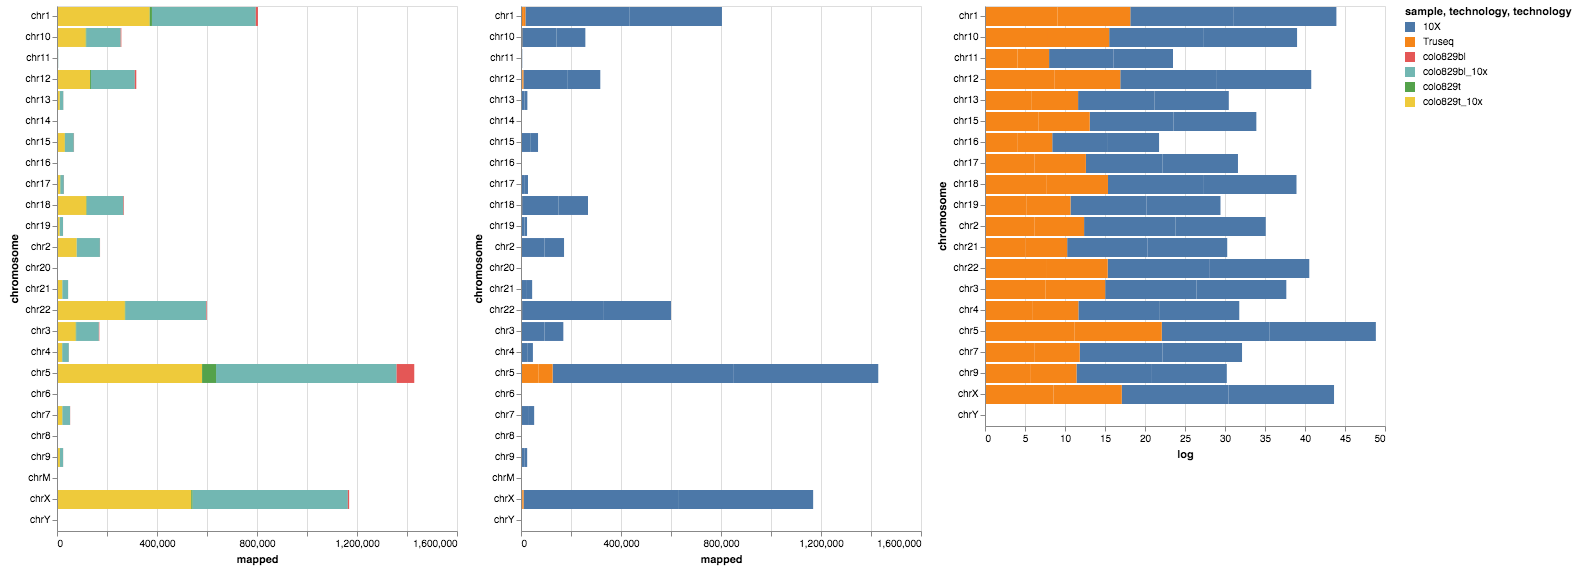

In [8]:
colo829bl_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-10X-sliced-idxstats-hg38.hist.csv")
colo829t_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-10X-sliced-idxstats-hg38.hist.csv")
colo829bl = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-sliced-idxstats-hg38.hist.csv")
colo829t = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-sliced-idxstats-hg38.hist.csv")

colo829bl_10x['technology'] = '10X'
colo829bl_10x['sample'] = 'colo829bl_10x'
colo829t_10x['technology'] = '10X'
colo829t_10x['sample'] = 'colo829t_10x'

colo829t['technology'] = 'Truseq'
colo829t['sample'] = 'colo829t'
colo829bl['technology'] = 'Truseq'
colo829bl['sample'] = 'colo829bl'

datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]

datasets = pd.concat(datasets, ignore_index=True)
datasets["log"] = datasets["mapped"].apply(np.log)


sample_chart = alt.Chart(datasets).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'sample:N'
)

tech_chart = alt.Chart(datasets).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)

logplot = alt.Chart(datasets).mark_bar().encode(
        x = 'log:Q',
        y = 'chromosome:N',
        color = 'technology:N'
)


sample_chart | tech_chart | logplot